In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
import tensorflow as tf
from PIL import Image as pil_image
import keras.backend as k

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
!unzip /content/Drive/MyDrive/data.zip -d /home/data

Streaming output truncated to the last 5000 lines.
  inflating: /home/data/normal2_patient329_SR_2_IM00024.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00025.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00026.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00028.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00029.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00030.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00031.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00032.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00033.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00034.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00035.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00036.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00037.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00038.tif  
  inflating: /home/data/normal2_patient329_SR_2_IM00039.tif  
  inflating: /home/

In [ ]:
tifCounter = 0
for root, dirs, files in os.walk('/home/data'):
    for file in files:    
        
            tifCounter += 1
print(tifCounter)

12058


In [ ]:
# Ici, nous définissons les générateurs de données pour appliquer des méthodes d'augmentation de données
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,zoom_range=0.05,rotation_range=360,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05)
test_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()


train_df =pd.read_csv('/content/Drive/MyDrive/csv/train.csv') #raed train csv file
validation_df = pd.read_csv('/content/Drive/MyDrive/csv/validation.csv') #raed validation csv file (Validation in the training process)

train_df = shuffle(train_df) #Shuffle the train data

test_df = pd.read_csv('/content/Drive/MyDrive/csv/test.csv')#raed test csv file (For evaluating the final version of the trained network)

In [ ]:
shape=(512,512,1)

In [ ]:
#la création des générateurs 
train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      directory='/home/data',
      x_col="filename",
      y_col="class",
      target_size=shape[:2],
      batch_size=14,
      class_mode='categorical',color_mode="grayscale",shuffle=True)
validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='/home/data',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=10,
        class_mode='categorical',color_mode="grayscale",shuffle=True)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='/home/data',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=10,
        class_mode='categorical',color_mode="grayscale",shuffle=True)

Found 3736 validated image filenames belonging to 2 classes.
Found 912 validated image filenames belonging to 2 classes.
Found 8322 validated image filenames belonging to 2 classes.


In [ ]:


###################################################################

base_model = Xception(weights=None, include_top=False, input_tensor=Input(shape=(512,512,1))) #Load the Xception model without weights
###################################################################


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(2,activation='softmax')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20860904  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 20,865,002
Trainable params: 20,810,474
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
full_name='Xception-10Epochs'

filepath="/content/Drive/MyDrive/models/%s-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name  # Path to save the trained models
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]



In [ ]:
model.fit(train_generator, epochs=10,validation_data=validation_generator,callbacks=callbacks_list) #start training

Epoch 1/10
267/267 [==============================] - 450s 2s/step - loss: 0.6159 - accuracy: 0.7096 - val_loss: 0.7316 - val_accuracy: 0.4934
Epoch 2/10
267/267 [==============================] - 410s 2s/step - loss: 0.3519 - accuracy: 0.8607 - val_loss: 0.5335 - val_accuracy: 0.9013
Epoch 3/10
267/267 [==============================] - 408s 2s/step - loss: 0.2472 - accuracy: 0.9142 - val_loss: 0.3066 - val_accuracy: 0.9397
Epoch 4/10
267/267 [==============================] - 407s 2s/step - loss: 0.1835 - accuracy: 0.9303 - val_loss: 5.7682 - val_accuracy: 0.5603
Epoch 5/10
267/267 [==============================] - 406s 2s/step - loss: 0.1608 - accuracy: 0.9377 - val_loss: 0.3816 - val_accuracy: 0.8991
Epoch 6/10
267/267 [==============================] - 406s 2s/step - loss: 0.1839 - accuracy: 0.9367 - val_loss: 0.5491 - val_accuracy: 0.7939
Epoch 7/10
267/267 [==============================] - 407s 2s/step - loss: 0.1282 - accuracy: 0.9584 - val_loss: 0.5187 - val_accuracy: 0.9167

In [ ]:
netpath="/content/Drive/MyDrive/models/Xception-10Epochs-10-0.9693.hdf5"

net=keras.models.load_model(netpath) #load model

 

In [ ]:
covid_label= test_generator.class_indices['covid'] #get l'index de la classe COVID-19 
normal_label= test_generator.class_indices['normal']  #get l'index de la classe normale


In [ ]:
print(normal_label)

1


In [ ]:
tp=0 #True Positives
fp=0 #False Positives
anum=0 #All the images numbers
tn=0 #true negative
fn=0 #false negative



In [ ]:
for num,img_name in enumerate(test_generator.filenames): #load image
    gt_ind=test_generator.classes[num] #get the loaded image class index
    img=cv2.imread(os.path.join('/home/data',img_name),cv2.IMREAD_UNCHANGED) #load image
    pred_ind=np.argmax(net.predict(np.expand_dims(np.expand_dims(img,axis=0),axis=3))[0]) #get the predicted class index
    anum+=1 #count the number of images
    if gt_ind==covid_label:
      
      if pred_ind==covid_label:
        tp+=1
        
      else:
        fp+=1
        
    elif gt_ind==normal_label:
      
      if pred_ind==normal_label:
        tn+=1
      else:
        fn+=1

In [ ]:
overall_acc=((tp+tn)/(tp+tn+fp+fn))
print(overall_acc)

0.9753664984378755


In [ ]:
print ("number of images is ",anum)
print("number of true positives is",tp)
print("number of true negatives is",tn)
print("number of false positives is",fp)
print("number of false negatives is",fn)
print("the overall acuracy on the test dataset of our model is :",overall_acc)

number of images is  8322
number of true positives is 443
number of true negatives is 7674
number of false positives is 19
number of false negatives is 186
the overall acuracy on the test dataset of our model is : 0.9753664984378755


In [ ]:
#Le réseau de classification des patients entièrement automatisé
netpath="/content/Drive/MyDrive/models/Xception-10Epochs-10-0.9693.hdf5" #path to the saved model

data_path='/content/Drive/MyDrive/PicturesForTest/CovidPatient.tif' #path to the folder containing patient's CT scan images

net=keras.models.load_model(netpath) #load model


covid_label=0 # index of COVID-19 class 
normal_label=1  # index of normal class 


img=cv2.imread(data_path,cv2.IMREAD_UNCHANGED)
pred_ind=np.argmax(net.predict(np.expand_dims(np.expand_dims(img,axis=0),axis=3))[0]) #predicted label
if pred_ind==normal_label:
  print('The patient is identified as normal')
else:
  print('The patient is identified as infected to COVID-19')



The patient is identified as infected to COVID-19


In [ ]:
#!ls /home/data


In [ ]:
#shutil.copy('/home/data/normal4_patient234_SR_2_IM00016.tif','/content/Drive/MyDrive/PicturesForTest')

'/content/Drive/MyDrive/PicturesForTest/normal4_patient234_SR_2_IM00016.tif'

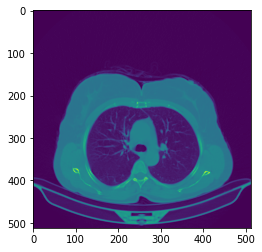

In [ ]:
# This code converts a 16bit uint TIFF image (that can not be displayed by normal monitors) to a Visualizable TIFF image



path='/content/Drive/MyDrive/PicturesForTest/NormalPatient.tif' #path to the image

with open(path, 'rb') as f:
 tiff = pil_image.open(io.BytesIO(f.read()))
array=np.array(tiff)
max_val=np.amax(array)
normalized=(array/max_val)
im = pil_image.fromarray(normalized)
plt.imshow(np.array(im))